# **1. MCS**

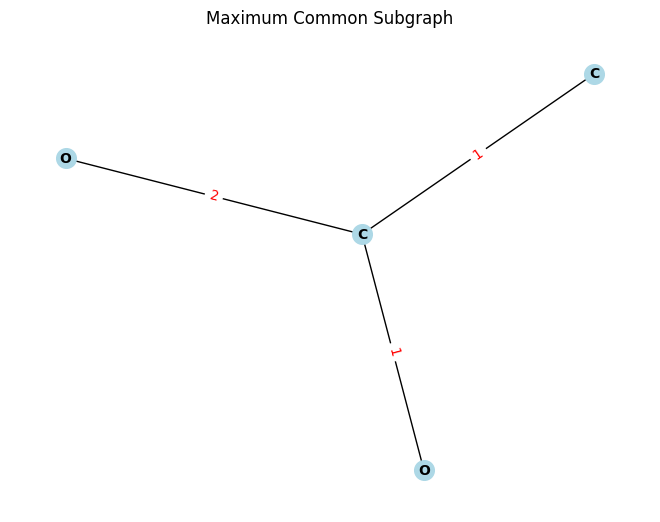

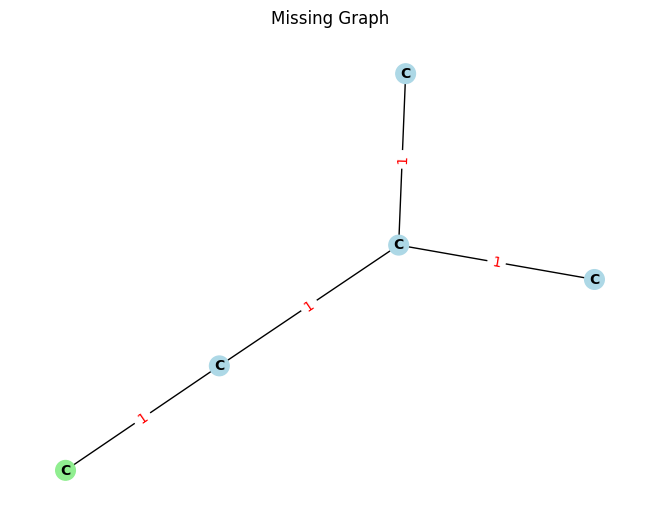

Boundary nodes: {4}


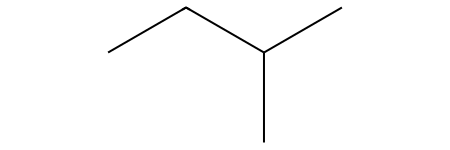

In [1]:
import sys
sys.path.append('../')
from SynRBL.SynMCS.chem_graph_analyzer import ChemicalGraphAnalyzer
reactant_smiles = 'CC(C)CCOC(C)=O'
product_smiles = 'CC(=O)O'

analyzer = ChemicalGraphAnalyzer()
mcs_graph, missing_graph, boundary_nodes = analyzer.analyze_reactant_product(reactant_smiles, product_smiles, display=True)
print("Boundary nodes:", boundary_nodes)
display(analyzer.graph_to_molecule(missing_graph, return_mol=True, return_smiles=False))

# **2. Find Missing**

In [2]:
import sys
sys.path.append('../')
from SynRBL.rsmi_utils import *
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from SynRBL.rsmi_utils import load_database
reactions_clean = load_database('../Data/reaction_clean.json.gz')
data = pd.DataFrame(reactions_clean)
data = data[(data['Unbalance']=='Products')|(data['Unbalance']=='Reactants')]
test_cases =data.to_dict('records')

In [3]:
def filter_by_carbon_count(data, col_name='Diff_formula', min_carbon=0, max_carbon=5):
    """
    Filter dictionaries based on the carbon count specified in a given column.

    This function filters the input list of dictionaries by checking the carbon ('C') count
    within a specified column. Only dictionaries where the carbon count falls within the
    specified minimum and maximum range are included in the output.

    Args:
        data (list of dict): A list of dictionaries to be filtered.
        col_name (str): The name of the column (key in dictionaries) to look for carbon count.
                        Defaults to 'Diff_formula'.
        min_carbon (int): The minimum allowed value of "C". Defaults to 0.
        max_carbon (int): The maximum allowed value of "C". Defaults to 5.

    Returns:
        list of dict: A list of dictionaries filtered based on the carbon count.
    """
    filtered_data = [
        item for item in data
        if "C" in item.get(col_name, {}) and min_carbon <= item[col_name].get("C", 0) <= max_carbon
    ]
    return filtered_data

# Example usage
# Filtering data with carbon count between 2 and 6
filtered_data = filter_by_carbon_count(data=test_cases, col_name='Diff_formula', min_carbon=3, max_carbon=10)
print(len(filtered_data))


6400


In [72]:
from pysmiles import read_smiles
import networkx as nx
def convert_smiles_to_graph(smiles):
        """
        Converts a concatenated SMILES string to a single disconnected NetworkX graph. 
        Each individual SMILES string in the concatenated input is converted to a separate graph,
        and these graphs are then combined into a single disconnected graph.

        Args:
            smiles (str): A concatenated SMILES string representing multiple chemical compounds.

        Returns:
            networkx.Graph: A single disconnected graph representation of the given SMILES strings.
        """
        # Split the SMILES string into individual SMILES strings
        individual_smiles = smiles.split('.')

        # Initialize an empty graph to combine individual graphs
        combined_graph = nx.Graph()

        # Convert each individual SMILES string to a graph and add it to the combined graph
        for ind_smile in individual_smiles:
            individual_graph = read_smiles(Chem.CanonSmiles(ind_smile), explicit_hydrogen=False, reinterpret_aromatic=False)

            # Combine the individual graph with the overall graph
            combined_graph = nx.disjoint_union(combined_graph, individual_graph)

        return combined_graph

In [73]:
filtered_data[0]

{'id': 'US05849732',
 'class': 6,
 'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'Unbalance': 'Products',
 'Diff_formula': {'C': 8, 'O': 2, 'H': 6}}

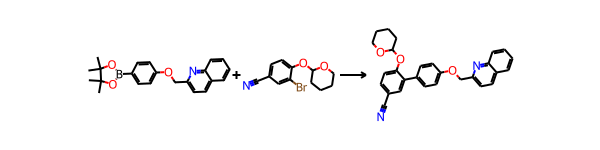

In [74]:
from rdkit.Chem import AllChem, rdChemReactions
test1= filtered_data[1]
display(rdChemReactions.ReactionFromSmarts(test1['reactions'], useSmiles= True))

reactant_graph = convert_smiles_to_graph(test1['reactants'])
product_graph = convert_smiles_to_graph(test1['products'])

In [78]:
nx.is_connected(reactant_graph)

False

AttributeError: 'set' object has no attribute 'nodes'

In [79]:
nx.is_connected(product_graph)

True

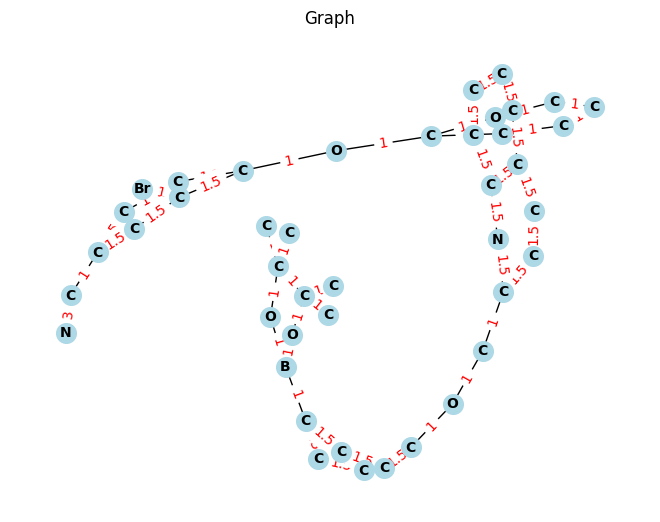

In [75]:
ChemicalGraphAnalyzer.display_graph(reactant_graph)

In [80]:
def find_maximum_common_subgraph(graph1, graph2, ignore_atom_type=False, ignore_bond_type=True):
    """
    Finds the Maximum Common Subgraph (MCS) between two graphs, one of which may be disconnected.

    Args:
        graph1, graph2 (networkx.Graph): Graphs to compare.
        ignore_atom_type (bool): If True, ignores atom types in comparison.
        ignore_bond_type (bool): If True, ignores bond types in comparison.

    Returns:
        networkx.Graph: The MCS of the two graphs, or None if no MCS found.
    """
    # Custom matching functions for nodes and edges
    node_match_func = lambda a, b: ((a['element'] == b['element']))
    edge_match_func = lambda a, b: (a['order'] == b['order'])

    # Determine the appropriate matcher based on the arguments
    if ignore_bond_type and not ignore_atom_type:
        matcher_func = lambda g1, g2: nx.algorithms.isomorphism.GraphMatcher(g1, g2, node_match=node_match_func)
    elif not ignore_bond_type and ignore_atom_type:
        matcher_func = lambda g1, g2: nx.algorithms.isomorphism.GraphMatcher(g1, g2, edge_match=edge_match_func)
    elif ignore_bond_type and ignore_atom_type:
        matcher_func = lambda g1, g2: nx.algorithms.isomorphism.GraphMatcher(g1, g2)
    else:
        matcher_func = lambda g1, g2: nx.algorithms.isomorphism.GraphMatcher(g1, g2, node_match=node_match_func, edge_match=edge_match_func)

    max_size = 0
    max_subgraph = None

    # If graph1 is disconnected, iterate through its connected components
    for subgraph1 in (graph1.subgraph(c) for c in nx.connected_components(graph1)):
        graph_matcher = matcher_func(subgraph1, graph2)

        # Find the largest isomorphic subgraph
        try:
            subgraph_isomorphisms = list(graph_matcher.subgraph_isomorphisms_iter())
            if subgraph_isomorphisms:
                mcs = max(subgraph_isomorphisms, key=len)
                if len(mcs) > max_size:
                    max_size = len(mcs)
                    max_subgraph = subgraph1.subgraph(mcs)
        except ValueError:
            pass  # No MCS found for this component, continue with next component

    return max_subgraph

In [85]:
node_match_func = lambda a, b: ((a['element'] == b['element']))
edge_match_func = lambda a, b: (a['order'] == b['order'])

# Determine the appropriate matcher based on the arguments
matcher_func = lambda g1, g2: nx.algorithms.isomorphism.GraphMatcher(reactant_graph, product_graph, node_match=node_match_func)

In [93]:
product_smiles

'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

In [87]:
for subgraph1 in (reactant_graph.subgraph(c) for c in nx.connected_components(reactant_graph)):
    #ChemicalGraphAnalyzer.display_graph(subgraph1)
    graph_matcher = matcher_func(subgraph1, product_graph)
    subgraph_isomorphisms = list(graph_matcher.subgraph_isomorphisms_iter())

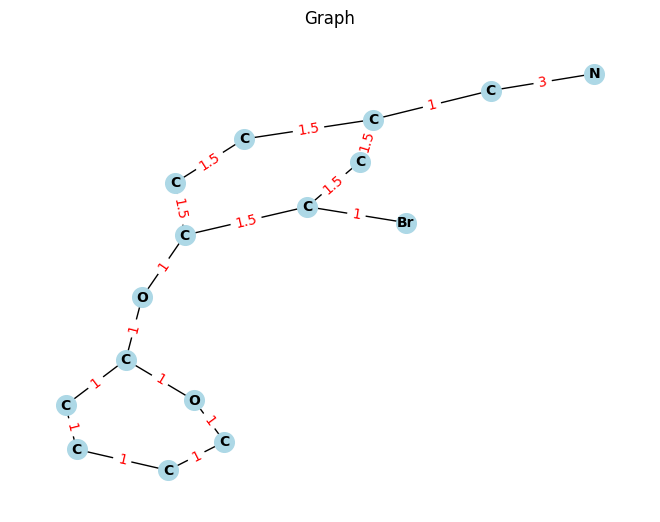

In [90]:
ChemicalGraphAnalyzer.display_graph(subgraph1)

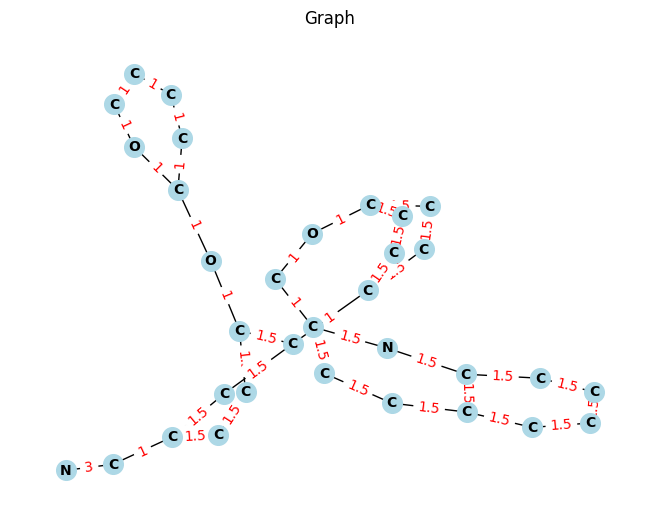

In [91]:
ChemicalGraphAnalyzer.display_graph(product_graph)

In [81]:
ChemicalGraphAnalyzer.display_graph(find_maximum_common_subgraph(reactant_graph, product_graph))

TypeError: 'NoneType' object is not iterable

In [40]:
# check:
import logging
import sys
from rdkit import Chem
import rdkit
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
# Create a log file to redirect the warnings
log_file = 'rdkit_warnings.log'

logging.basicConfig(filename=log_file, level=logging.WARNING)

# Redirect warnings to the log file
rdkit_logger = logging.getLogger('rdkit')
rdkit_logger.addHandler(logging.StreamHandler(sys.stdout))

# Suppress RDKit warnings in the console
rdkit_logger.setLevel(logging.ERROR)
rdkit.RDLogger.DisableLog('rdApp.*')

for key, test in enumerate(filtered_data[1:2]):
    reactant_smiles = test['reactants']
    product_smiles = test['products']
    try:
        analyzer = ChemicalGraphAnalyzer()
        mcs_graph, missing_graph, boundary_nodes = analyzer.analyze_reactant_product(reactant_smiles, product_smiles, display=False)
    except:
        print(key)
# Close the log file when you're done
logging.shutdown()


NO MCS
0


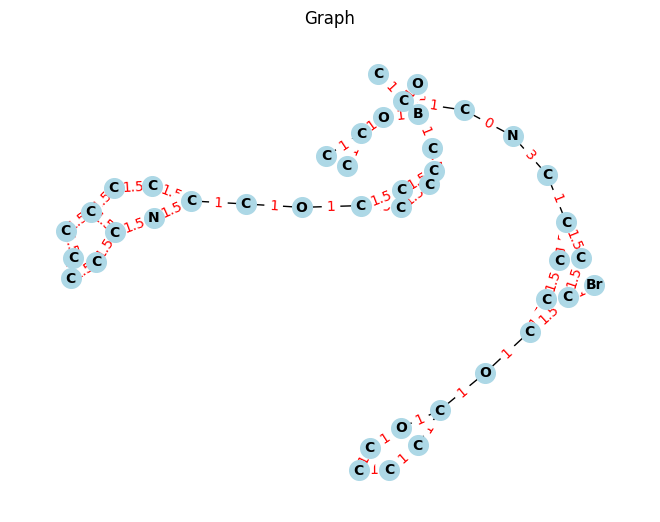

In [44]:
analyzer.display_graph(analyzer.convert_smiles_to_graph(reactant_smiles))

In [47]:
reactant_smiles

'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'

In [53]:
import networkx as nx
from pysmiles import read_smiles
def convert_smiles_to_graph(smiles):
        """
        Converts a concatenated SMILES string to a single disconnected NetworkX graph. 
        Each individual SMILES string in the concatenated input is converted to a separate graph,
        and these graphs are then combined into a single disconnected graph.

        Args:
            smiles (str): A concatenated SMILES string representing multiple chemical compounds.

        Returns:
            networkx.Graph: A single disconnected graph representation of the given SMILES strings.
        """
        # Split the SMILES string into individual SMILES strings
        individual_smiles = smiles.split('.')

        # Initialize an empty graph to combine individual graphs
        combined_graph = nx.Graph()

        # Convert each individual SMILES string to a graph and add it to the combined graph
        for ind_smile in individual_smiles:
            individual_graph = read_smiles(Chem.CanonSmiles(ind_smile), explicit_hydrogen=False, reinterpret_aromatic=False)

            # Combine the individual graph with the overall graph
            combined_graph = nx.disjoint_union(combined_graph, individual_graph)

        return combined_graph

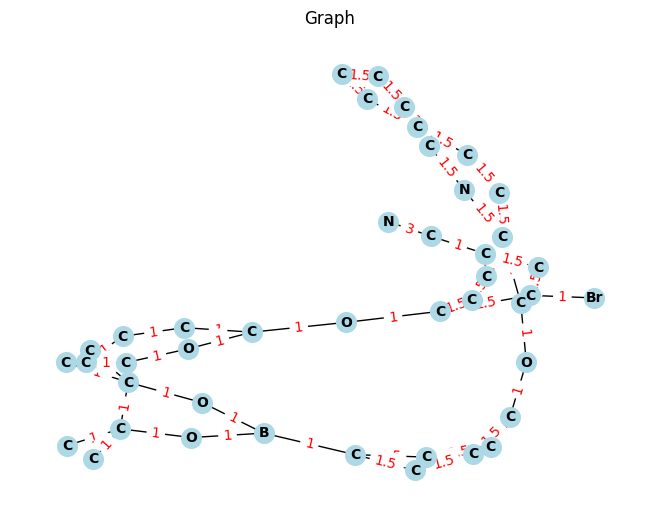

In [55]:
test = convert_smiles_to_graph(reactant_smiles)
ChemicalGraphAnalyzer.display_graph(test)

In [36]:
analyzer.find_maximum_common_subgraph(analyzer.convert_smiles_to_graph(reactant_smiles), analyzer.convert_smiles_to_graph(product_smiles))

In [29]:
analyzer = ChemicalGraphAnalyzer()
mcs_graph, missing_graph, boundary_nodes = analyzer.analyze_reactant_product(reactant_smiles, product_smiles, display=False)

NO MCS


TypeError: cannot unpack non-iterable NoneType object

In [30]:
analyzer.analyze_reactant_product(reactant_smiles, product_smiles, display=False)

NO MCS


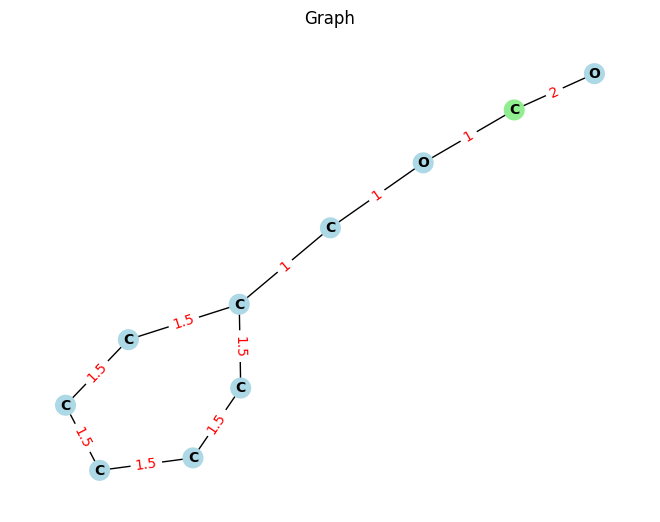

In [42]:
analyzer.display_graph(missing_graph, highlight_nodes=boundary_nodes)

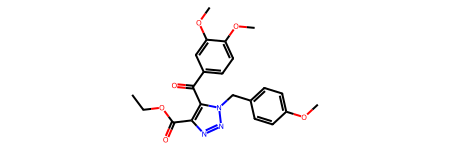

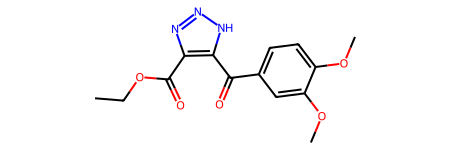

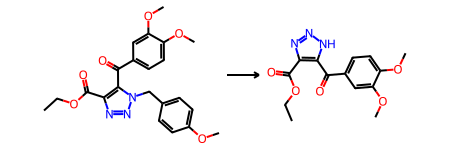

In [204]:
from rdkit.Chem import AllChem, rdChemReactions
test1= filtered_data[3]
product_smiles = test1['products']
reactant_smiles = test1['reactants']
display(Chem.MolFromSmiles(reactant_smiles))
display(Chem.MolFromSmiles(product_smiles))
display(rdChemReactions.ReactionFromSmarts(test1['reactions'], useSmiles= True))


reactant_graph = ChemicalGraphAnalyzer.convert_smiles_to_graph(reactant_smiles)
product_graph = ChemicalGraphAnalyzer.convert_smiles_to_graph(product_smiles)


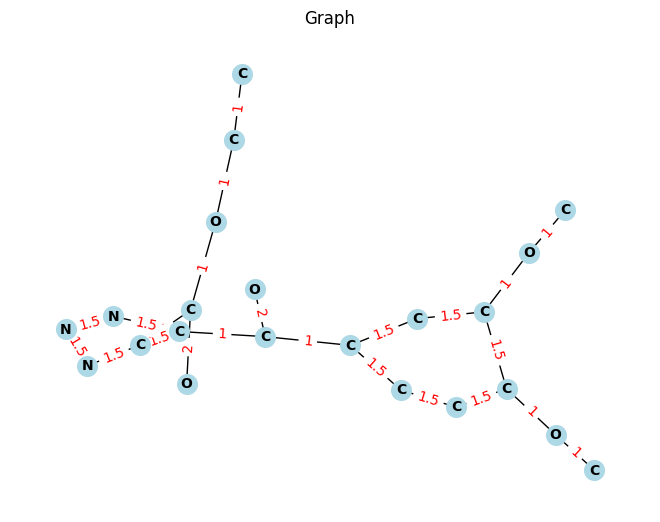

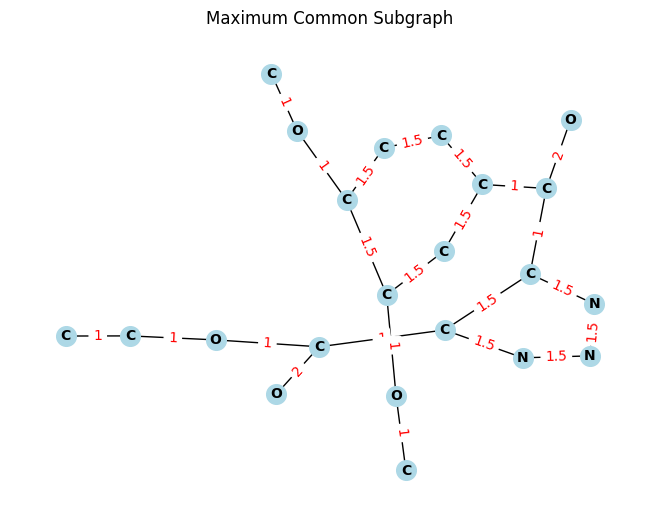

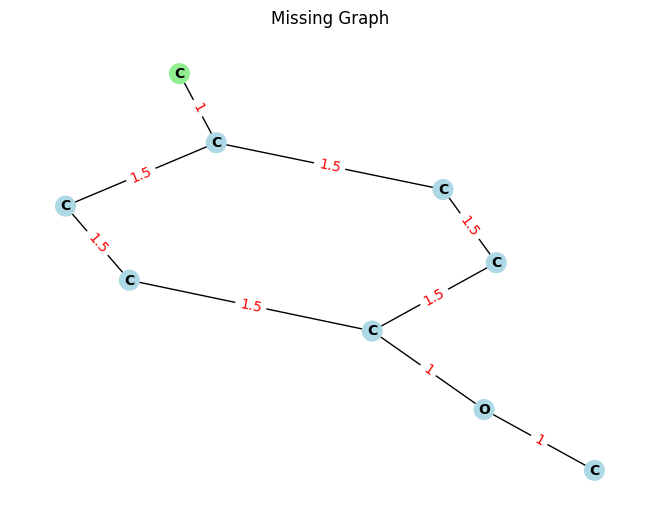

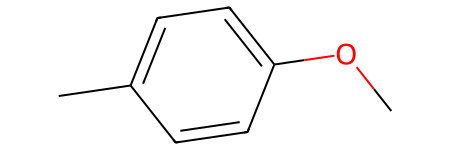

In [200]:
# Example usage
mcs_graph, missing_graph, boundary_nodes = ChemicalGraphAnalyzer.analyze_reactant_product(test1['reactants'], test1['products'], display=True)
ChemicalGraphAnalyzer.graph_to_molecule(missing_graph, return_mol=True, return_smiles=False)

In [180]:
reactant_smiles

'CCOC(=O)c1nnn(Cc2ccc(OC)cc2)c1C(=O)c1ccc(OC)c(OC)c1'

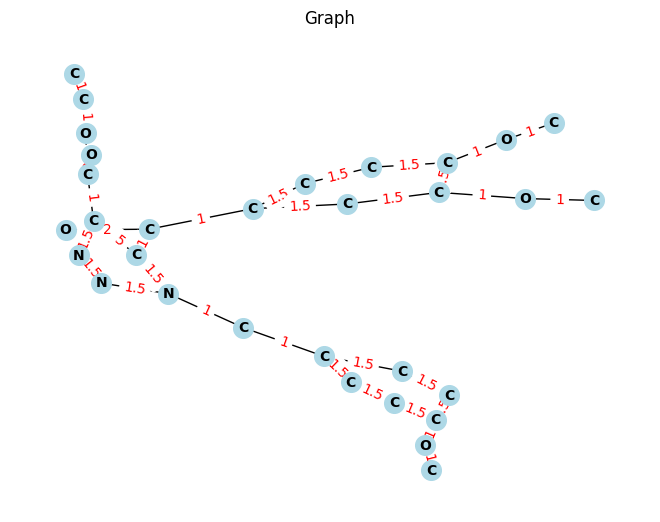

In [183]:
ChemicalGraphAnalyzer.display_graph(reactant_graph)

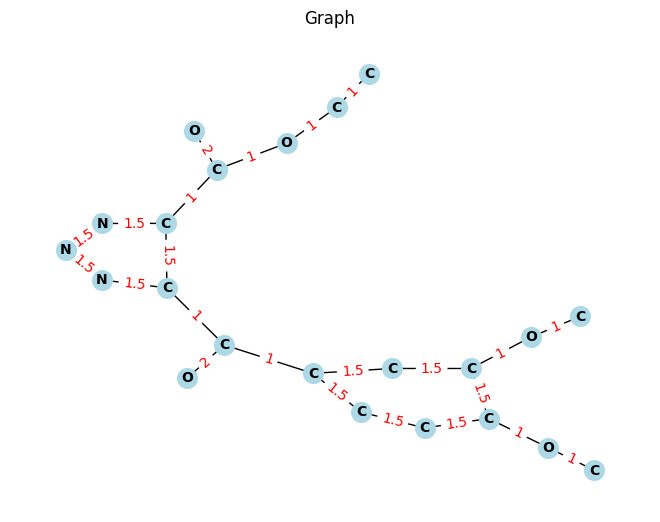

In [182]:
ChemicalGraphAnalyzer.display_graph(product_graph)

In [205]:
import networkx as nx
from itertools import combinations
from joblib import Parallel, delayed

def are_graphs_comparable(G1, G2):
    """Check if two graphs have the same number of nodes and matching degree sequences."""
    if G1.number_of_nodes() != G2.number_of_nodes():
        return False
    return sorted([d for n, d in G1.degree()]) == sorted([d for n, d in G2.degree()])

def check_isomorphic(subnodes1, G1, G2):
    """Check if subgraphs induced by subnodes1 in G1 and subgraphs in G2 are isomorphic."""
    subG1 = G1.subgraph(subnodes1)
    for subnodes2 in combinations(G2.nodes(), len(subnodes1)):
        subG2 = G2.subgraph(subnodes2)
        if nx.is_isomorphic(subG1, subG2):
            return subG1.number_of_nodes()
    return 0

def find_mcs_disconnected(G1, G2):
    max_size = 0

    # Prepare tasks for parallel processing
    tasks = (delayed(check_isomorphic)(subnodes1, G1, G2)
             for n in range(1, min(G1.number_of_nodes(), G2.number_of_nodes()) + 1)
             for subnodes1 in combinations(G1.nodes(), n)
             if are_graphs_comparable(G1.subgraph(subnodes1), G2))

    # Parallel computation
    results = Parallel(n_jobs=-1)(tasks)

    # Find the maximum size
    max_size = max(results, default=0)

    return max_size

# Example usage
G1 = reactant_graph
G2 = product_graph

# Add nodes and edges to G1 and G2

size = find_mcs_disconnected(G1, G2)
print("Size of Maximum Common Disconnected Subgraph:", size)


In [189]:
node_match_func = lambda a, b: ((a['element'] == b['element']) and (a['aromatic'] == b['aromatic'])) 
edge_match_func = lambda a, b: (a['order'] == b['order']) 
        


graph_matcher = nx.algorithms.isomorphism.GraphMatcher(reactant_graph, product_graph,node_match=node_match_func)
mcs = max(graph_matcher.subgraph_isomorphisms_iter(), key=len)
mcs_graph = reactant_graph.subgraph(mcs)

In [190]:
display(mcs_graph)

In [170]:
mcs_graph

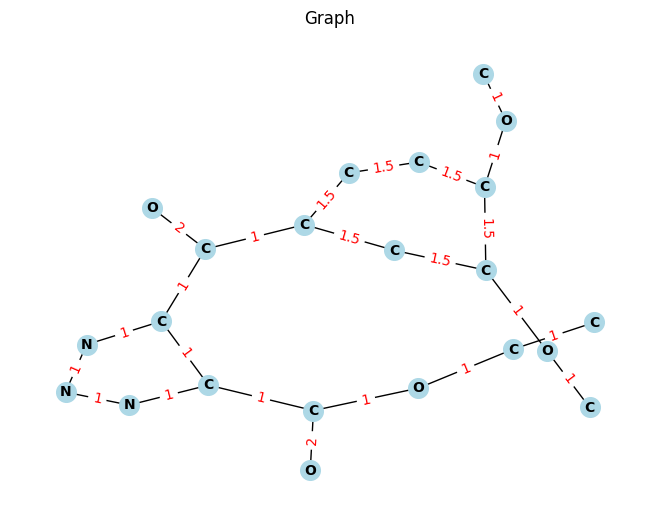

In [171]:
ChemicalGraphAnalyzer.display_graph(mcs_graph)

In [ ]:

ChemicalGraphAnalyzer.display_graph(find_maximum_common_subgraph(product_graph,reactant_graph,ignore_atom_type=True, ignore_bond_type=True))

In [145]:
# Example usage
mcs_graph, missing_graph, boundary_nodes = ChemicalGraphAnalyzer.analyze_reactant_product(test1['reactants'], test1['products'], display=True)
ChemicalGraphAnalyzer.graph_to_molecule(missing_graph, return_mol=True, return_smiles=False)

TypeError: 'NoneType' object is not iterable

In [146]:
ChemicalGraphAnalyzer.find_maximum_common_subgraph(reactant_graph, product_graph, ignore_atom_type=False, ignore_bond_type=True)

In [ ]:
ChemicalGraphAnalyzer.find_maximum_common_subgraph(missing_graph,)

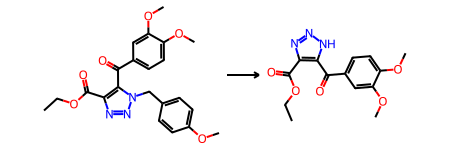

In [75]:
from rdkit.Chem import AllChem, rdChemReactions
smi = test1['reactions']
rxn = rdChemReactions.ReactionFromSmarts(smi, useSmiles= True)

rxn

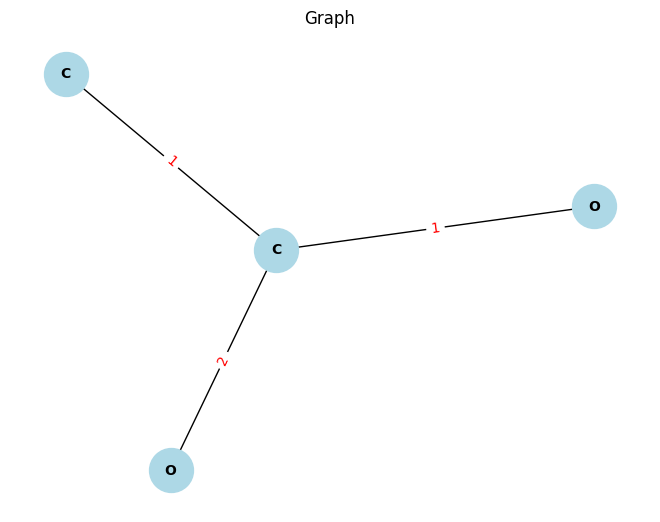

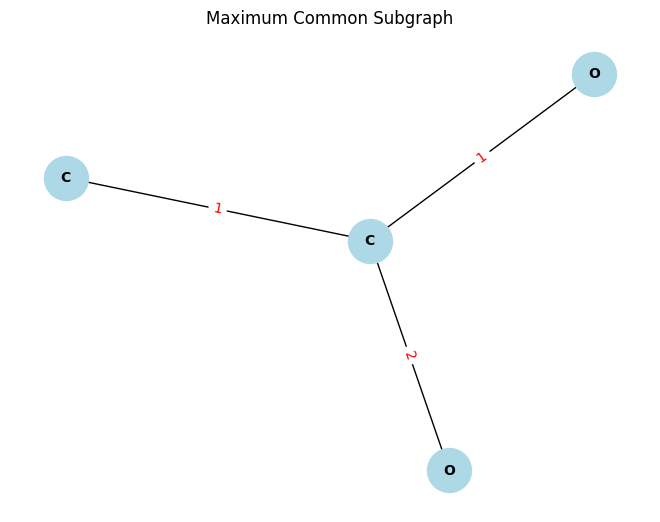

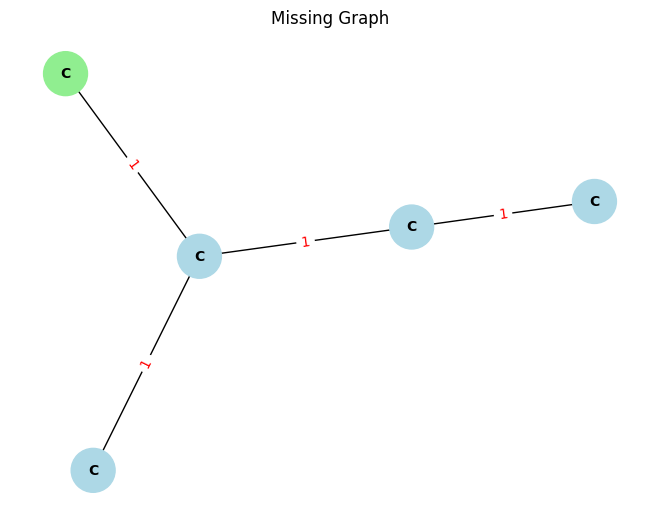

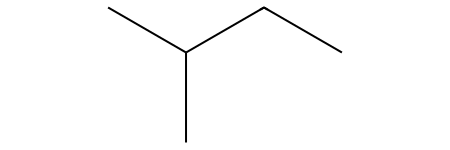

In [70]:
import networkx as nx
from pysmiles import read_smiles
import matplotlib.pyplot as plt
from rdkit.Chem import rdmolops
from rdkit import Chem

class ChemicalGraphAnalyzer:
    """
    A class for analyzing chemical graphs based on SMILES strings.
    
    Provides functionality to convert SMILES to graphs, find the Maximum Common Subgraph (MCS),
    subtract graphs, identify boundary nodes, and display graphs.
    """

    @staticmethod
    def convert_smiles_to_graph(smiles):
        """
        Converts a SMILES string to a NetworkX graph.

        Args:
            smiles (str): A SMILES string representing a chemical compound.

        Returns:
            networkx.Graph: A graph representation of the given SMILES string.
        """
        return read_smiles(smiles, explicit_hydrogen=False)

    @staticmethod
    def find_maximum_common_subgraph(graph1, graph2, ignore_atom_type=False, ignore_bond_type=True):
        """
        Finds the Maximum Common Subgraph (MCS) between two graphs.

        Args:
            graph1, graph2 (networkx.Graph): Graphs to compare.
            ignore_atom_type (bool): If True, ignores atom types in comparison.
            ignore_bond_type (bool): If True, ignores bond types in comparison.

        Returns:
            networkx.Graph: The MCS of the two graphs, or None if no MCS found.
        """
        # Custom matching functions for nodes and edges
        node_match_func = lambda a, b: ((a['element'] == b['element']) and (a['charge'] == b['charge']) and (a['aromatic'] == b['aromatic'])) or ignore_atom_type
        edge_match_func = lambda a, b: (a['order'] == b['order']) or ignore_bond_type

        graph_matcher = nx.algorithms.isomorphism.GraphMatcher(graph1, graph2, node_match=node_match_func, edge_match=edge_match_func)
        try:
            mcs = max(graph_matcher.subgraph_isomorphisms_iter(), key=len)
            return graph1.subgraph(mcs)
        except ValueError:
            return None

    @staticmethod
    def subtract_graphs(main_graph, sub_graph):
        """
        Subtracts one graph from another.

        Args:
            main_graph (networkx.Graph): The graph from which to subtract.
            sub_graph (networkx.Graph): The graph to be subtracted.

        Returns:
            networkx.Graph: The resulting graph after subtraction.
        """
        result_graph = main_graph.copy()
        for node in sub_graph.nodes():
            if node in result_graph:
                result_graph.remove_node(node)
        return result_graph

    @staticmethod
    def identify_boundary_nodes(mcs_graph, main_graph):
        """
        Identifies boundary nodes in the MCS that have edges to nodes not in MCS.

        Args:
            mcs_graph (networkx.Graph): The Maximum Common Subgraph.
            main_graph (networkx.Graph): The main graph to compare with.

        Returns:
            set: A set of boundary nodes.
        """
        boundary_nodes = set()
        for node in mcs_graph.nodes():
            for neighbor in main_graph.neighbors(node):
                if neighbor not in mcs_graph:
                    boundary_nodes.add(node)
        return boundary_nodes

    @staticmethod
    def display_graph(graph, title='Graph', highlight_nodes=None):
        """
        Displays a graph using matplotlib.

        Args:
            graph (networkx.Graph): The graph to be displayed.
            title (str): Title of the graph.
            highlight_nodes (set): Nodes to be highlighted.
        """
        positions = nx.spring_layout(graph)
        node_labels = {node: data.get('element', node) for node, data in graph.nodes(data=True)}
        node_color_map = ['lightblue' if node not in highlight_nodes else 'lightgreen' for node in graph.nodes()] if highlight_nodes else 'lightblue'
        nx.draw(graph, positions, with_labels=True, labels=node_labels, node_size=1000, node_color=node_color_map, font_size=10, font_color='black', font_weight='bold')
        edge_labels = {(u, v): data.get('order', '') for u, v, data in graph.edges(data=True)}
        nx.draw_networkx_edge_labels(graph, positions, edge_labels=edge_labels, font_color='red')
        plt.title(title)
        plt.show()
    @staticmethod
    def graph_to_molecule(graph, return_smiles = True, return_mol = False ):
        """
        Converts a NetworkX graph to a molecule using RDKit.

        Args:
            graph (networkx.Graph): A graph representation of a molecule, 
                                    with nodes having 'element' attributes 
                                    and edges having 'order' attributes.

        Returns:
            str: The SMILES representation of the molecule.
        """
        mol = Chem.RWMol()

        # Map for bond types
        bond_type_map = {
            1: Chem.rdchem.BondType.SINGLE,
            2: Chem.rdchem.BondType.DOUBLE,
            3: Chem.rdchem.BondType.TRIPLE,
            'aromatic': Chem.rdchem.BondType.AROMATIC
        }

        # Add atoms to the molecule
        node_to_idx = {}
        for node, data in graph.nodes(data=True):
            atom = Chem.Atom(data['element'])
            mol_idx = mol.AddAtom(atom)
            node_to_idx[node] = mol_idx

        # Add bonds to the molecule
        for u, v, data in graph.edges(data=True):
            bond_type = data.get('order')
            rdkit_bond_type = bond_type_map.get(bond_type)
            if rdkit_bond_type:
                mol.AddBond(node_to_idx[u], node_to_idx[v], rdkit_bond_type)

        # Sanitize the molecule
        rdmolops.SanitizeMol(mol)
        if return_mol:
            return mol
        elif return_smiles:
            # Convert to SMILES
            smiles = Chem.MolToSmiles(mol)
            return smiles
        else:
            return mol, Chem.MolToSmiles(mol)
    
    @staticmethod
    def analyze_reactant_product(reactant_smiles, product_smiles, display=True):
        """
        Analyzes the reactant and product of a chemical reaction represented by SMILES strings.

        Args:
            reactant_smiles, product_smiles (str): SMILES strings of the reactant and product.
            display (bool): If True, displays the graphs.

        Returns:
            tuple: A tuple containing the MCS graph, the missing graph, and the set of boundary nodes.
        """
        reactant_graph = ChemicalGraphAnalyzer.convert_smiles_to_graph(reactant_smiles)
        product_graph = ChemicalGraphAnalyzer.convert_smiles_to_graph(product_smiles)
        mcs_graph = ChemicalGraphAnalyzer.find_maximum_common_subgraph(reactant_graph, product_graph)
        ChemicalGraphAnalyzer.display_graph(mcs_graph)
        if mcs_graph:

            if len(reactant_graph.nodes) >= len(product_graph.nodes):
                missing_graph = ChemicalGraphAnalyzer.subtract_graphs(reactant_graph, mcs_graph)
                main_graph = reactant_graph
            else:
                missing_graph = ChemicalGraphAnalyzer.subtract_graphs(product_graph, mcs_graph)
                main_graph = product_graph

            boundary_nodes = ChemicalGraphAnalyzer.identify_boundary_nodes(missing_graph, main_graph)

            if display:
                if mcs_graph:
                    ChemicalGraphAnalyzer.display_graph(nx.Graph(mcs_graph), 'Maximum Common Subgraph')
                else:
                    print("No Maximum Common Subgraph found.")

                if missing_graph:
                    ChemicalGraphAnalyzer.display_graph(nx.Graph(missing_graph), 'Missing Graph', highlight_nodes=boundary_nodes)
                else:
                    print("No missing part found.")

            return mcs_graph, missing_graph, boundary_nodes
        else:
            print('NO MCS')
    
       

# Example usage
mcs_graph, missing_graph, boundary_nodes = ChemicalGraphAnalyzer.analyze_reactant_product('CC(CC)COC(=O)C', 'CC(=O)O', display=True)
ChemicalGraphAnalyzer.graph_to_molecule(missing_graph, return_mol=True, return_smiles=False)


MCS SMARTS: [#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#7]:1):[#6]:[#6]:[#6]:[#6]:2


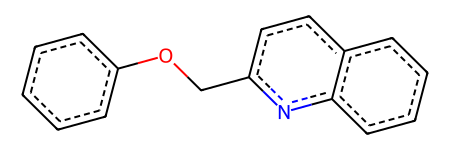

In [114]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

# Split the SMILES strings and convert each to a molecule
reactant_mols = [Chem.MolFromSmiles(smiles) for smiles in reactant_smiles.split('.')]
product_mols = [Chem.MolFromSmiles(smiles) for smiles in product_smiles.split('.')]

# Find the MCS between all reactants and all products
mcs_result = rdFMCS.FindMCS([reactant_mols[0], product_mols[0]])
mcs_smarts = mcs_result.smartsString

print("MCS SMARTS:", mcs_smarts)
Chem.MolFromSmarts(mcs_smarts)


Combined MCS SMILES: C1:C:C:C(OCC2:C:C:C3:C:C:C:C:C:3:N:2):C:C:1.N#CC1:C:C:C(OC2CCCCO2):C:C:1


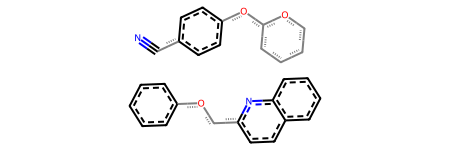

In [121]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

# Convert the product SMILES to a molecule
product_mol = Chem.MolFromSmiles(product_smiles)

# Split the reactant SMILES and convert each to a molecule
reactant_mols = [Chem.MolFromSmiles(smiles) for smiles in reactant_smiles.split('.')]

# Find the MCS for each reactant substructure with the product
mcs_mols = []
for reactant_mol in reactant_mols:
    mcs_result = rdFMCS.FindMCS([reactant_mol, product_mol])
    mcs_smarts = mcs_result.smartsString
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)
    if mcs_mol:
        mcs_mols.append(mcs_mol)

# Combine the MCS results into a single disconnected structure
combined_mol = Chem.RWMol()
for mcs_mol in mcs_mols:
    combined_mol = Chem.CombineMols(combined_mol, mcs_mol)

# Convert the combined molecule to SMILES
combined_smiles = Chem.MolToSmiles(combined_mol)
print("Combined MCS SMILES:", combined_smiles)

Chem.MolFromSmarts(combined_smiles)


In [117]:
product_mols

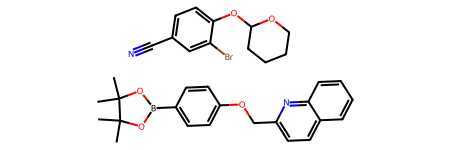

In [100]:
Chem.MolFromSmiles(reactant_smiles)

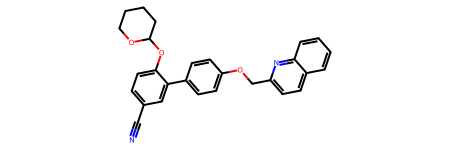

In [97]:
Chem.MolFromSmiles(product_smiles)

In [118]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions

def find_dissimilar_substructure(product_mol, mcs_mol):
    """
    Find the substructure in the product molecule that is not part of the MCS.

    Args:
        product_mol (rdkit.Chem.Mol): The product molecule.
        mcs_mol (rdkit.Chem.Mol): The MCS molecule.

    Returns:
        rdkit.Chem.Mol: The dissimilar substructure of the product molecule.
    """
    # Check if the MCS is a substructure of the product
    if product_mol.HasSubstructMatch(mcs_mol):
        # Find the matching atoms
        match = product_mol.GetSubstructMatch(mcs_mol)

        # Create an editable copy of the product molecule
        product_mol_editable = Chem.EditableMol(product_mol)

        # Remove the matched atoms
        for idx in sorted(match, reverse=True):
            product_mol_editable.RemoveAtom(idx)

        # Get the dissimilar substructure
        dissimilar_substructure = product_mol_editable.GetMol()

        return dissimilar_substructure
    else:
        return None

# Assuming you have `combined_mol` as your MCS and `product_mol` as your product molecule
# combined_mol = ... (your MCS molecule)
# product_mol = ... (your product molecule)

dissimilar_substructure = find_dissimilar_substructure(product_mols[0], combined_mol)
if dissimilar_substructure:
    print(Chem.MolToSmiles(dissimilar_substructure))
else:
    print("No dissimilar substructure found.")


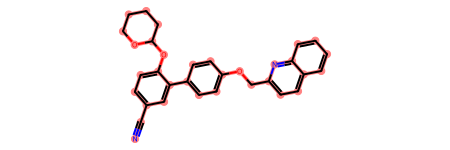

In [120]:
product_mols[0]

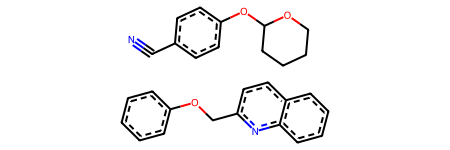

In [112]:
combined_mol

In [122]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition

def subtract_mcs(reactant_mol, mcs_mols):
    """
    Subtract the MCS from the reactant molecule to find the dissimilar substructure.
    
    Args:
        reactant_mol (rdkit.Chem.Mol): The reactant molecule.
        mcs_mols ([rdkit.Chem.Mol]): List of MCS substructures.

    Returns:
        rdkit.Chem.Mol: The dissimilar substructure of the reactant molecule.
    """
    editable_mol = Chem.EditableMol(reactant_mol)

    for mcs_mol in mcs_mols:
        match_idxs = reactant_mol.GetSubstructMatch(mcs_mol)
        for idx in sorted(match_idxs, reverse=True):
            editable_mol.RemoveAtom(idx)

    return editable_mol.GetMol()

# Combined MCS SMILES string
combined_mcs_smiles = 'C1:C:C:C(OCC2:C:C:C3:C:C:C:C:C:3:N:2):C:C:1.N#CC1:C:C:C(OC2CCCCO2):C:C:1'

# Splitting the MCS into its disconnected substructures
mcs_mols = [Chem.MolFromSmiles(smiles) for smiles in combined_mcs_smiles.split('.')]

# Reactant SMILES string
reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
reactant_mols = [Chem.MolFromSmiles(smiles) for smiles in reactant_smiles.split('.')]

# Finding the dissimilar substructure for each reactant
dissimilar_substructures = [subtract_mcs(reactant_mol, mcs_mols) for reactant_mol in reactant_mols]

# Print the SMILES of the dissimilar substructures
for substructure in dissimilar_substructures:
    print(Chem.MolToSmiles(substructure))


CC1(C)OBOC1(C)C
Br


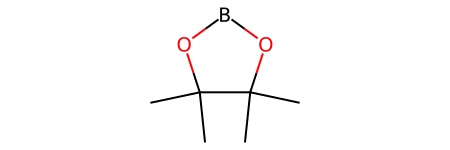

In [124]:
dissimilar_substructures[0]

## RDKit FindMCS flow

Combined MCS SMILES: C1:C:C:C(OCC2:C:C:C3:C:C:C:C:C:3:N:2):C:C:1.N#CC1:C:C:C(OC2CCCCO2):C:C:1


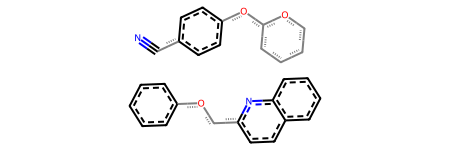

In [125]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

# Convert the product SMILES to a molecule
product_mol = Chem.MolFromSmiles(product_smiles)

# Split the reactant SMILES and convert each to a molecule
reactant_mols = [Chem.MolFromSmiles(smiles) for smiles in reactant_smiles.split('.')]

# Find the MCS for each reactant substructure with the product
mcs_mols = []
for reactant_mol in reactant_mols:
    mcs_result = rdFMCS.FindMCS([reactant_mol, product_mol])
    mcs_smarts = mcs_result.smartsString
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)
    if mcs_mol:
        mcs_mols.append(mcs_mol)

# Combine the MCS results into a single disconnected structure
combined_mol = Chem.RWMol()
for mcs_mol in mcs_mols:
    combined_mol = Chem.CombineMols(combined_mol, mcs_mol)

# Convert the combined molecule to SMILES
combined_smiles = Chem.MolToSmiles(combined_mol)
print("Combined MCS SMILES:", combined_smiles)

Chem.MolFromSmarts(combined_smiles)


In [127]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition

def subtract_mcs(reactant_mol, mcs_mols):
    """
    Subtract the MCS from the reactant molecule to find the dissimilar substructure.
    
    Args:
        reactant_mol (rdkit.Chem.Mol): The reactant molecule.
        mcs_mols ([rdkit.Chem.Mol]): List of MCS substructures.

    Returns:
        rdkit.Chem.Mol: The dissimilar substructure of the reactant molecule.
    """
    editable_mol = Chem.EditableMol(reactant_mol)

    for mcs_mol in mcs_mols:
        match_idxs = reactant_mol.GetSubstructMatch(mcs_mol)
        for idx in sorted(match_idxs, reverse=True):
            editable_mol.RemoveAtom(idx)

    return editable_mol.GetMol()

# Combined MCS SMILES string
combined_mcs_smiles = 'C1:C:C:C(OCC2:C:C:C3:C:C:C:C:C:3:N:2):C:C:1.N#CC1:C:C:C(OC2CCCCO2):C:C:1'

# Splitting the MCS into its disconnected substructures
mcs_mols = [Chem.MolFromSmiles(smiles) for smiles in combined_mcs_smiles.split('.')]

# Reactant SMILES string
reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
reactant_mols = [Chem.MolFromSmiles(smiles) for smiles in reactant_smiles.split('.')]

# Finding the dissimilar substructure for each reactant
dissimilar_substructures = [subtract_mcs(reactant_mol, mcs_mols) for reactant_mol in reactant_mols]

# Print the SMILES of the dissimilar substructures
for substructure in dissimilar_substructures:
    print(Chem.MolToSmiles(substructure))


CC1(C)OBOC1(C)C
Br


In [128]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem

class ChemicalGraphAnalyzer:
    def __init__(self):
        pass

    @staticmethod
    def convert_smiles_to_mols(smiles):
        """
        Converts a SMILES string (or concatenated SMILES strings) to a list of RDKit molecule objects.
        Args:
            smiles (str): A SMILES string or concatenated SMILES strings.
        Returns:
            List[rdkit.Chem.Mol]: A list of molecule objects.
        """
        return [Chem.MolFromSmiles(s) for s in smiles.split('.')]

    @staticmethod
    def find_mcs(mols):
        """
        Finds the Maximum Common Substructure (MCS) among a list of molecules.
        Args:
            mols (List[rdkit.Chem.Mol]): List of molecule objects.
        Returns:
            rdkit.Chem.Mol: The MCS molecule.
        """
        mcs_result = rdFMCS.FindMCS(mols)
        return Chem.MolFromSmarts(mcs_result.smartsString)

    @staticmethod
    def subtract_mcs(reactant_mol, mcs_mols):
        """
        Subtract the MCS from the reactant molecule to find the dissimilar substructure.
        Args:
            reactant_mol (rdkit.Chem.Mol): The reactant molecule.
            mcs_mols ([rdkit.Chem.Mol]): List of MCS substructures.
        Returns:
            rdkit.Chem.Mol: The dissimilar substructure of the reactant molecule.
        """
        editable_mol = Chem.EditableMol(reactant_mol)
        for mcs_mol in mcs_mols:
            match_idxs = reactant_mol.GetSubstructMatch(mcs_mol)
            for idx in sorted(match_idxs, reverse=True):
                editable_mol.RemoveAtom(idx)
        return editable_mol.GetMol()

    @staticmethod
    def analyze_dissimilarity(reactant_smiles, product_smiles):
        """
        Analyzes the dissimilarity between reactants and products based on their SMILES strings.
        Args:
            reactant_smiles (str): SMILES string for the reactants.
            product_smiles (str): SMILES string for the products.
        Returns:
            List[str]: List of SMILES strings representing the dissimilar substructures.
        """
        reactant_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(reactant_smiles)
        product_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(product_smiles)

        # Finding MCS for each reactant with the product
        mcs_mols = [ChemicalGraphAnalyzer.find_mcs([reactant_mol, product_mol]) for reactant_mol in reactant_mols for product_mol in product_mols]

        # Finding dissimilar substructures
        dissimilar_substructures = [ChemicalGraphAnalyzer.subtract_mcs(reactant_mol, mcs_mols) for reactant_mol in reactant_mols]

        # Returning the SMILES of the dissimilar substructures
        return [Chem.MolToSmiles(substructure) for substructure in dissimilar_substructures if substructure]




CC1(C)OBOC1(C)C
Br


In [138]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem

class ChemicalGraphAnalyzer:
    def __init__(self):
        pass

    @staticmethod
    def convert_smiles_to_mols(smiles):
        """
        Converts a SMILES string (or concatenated SMILES strings) to a list of RDKit molecule objects.
        Args:
            smiles (str): A SMILES string or concatenated SMILES strings.
        Returns:
            List[rdkit.Chem.Mol]: A list of molecule objects.
        """
        return [Chem.MolFromSmiles(s) for s in smiles.split('.')]

    @staticmethod
    def find_mcs(mols):
        """
        Finds the Maximum Common Substructure (MCS) among a list of molecules.
        Args:
            mols (List[rdkit.Chem.Mol]): List of molecule objects.
        Returns:
            rdkit.Chem.Mol: The MCS molecule.
        """
        mcs_result = rdFMCS.FindMCS(mols)
        return Chem.MolFromSmarts(mcs_result.smartsString)

    @staticmethod
    def subtract_mcs(reactant_mol, mcs_mols):
        """
        Subtract the MCS from the reactant molecule to find the dissimilar substructure.
        Args:
            reactant_mol (rdkit.Chem.Mol): The reactant molecule.
            mcs_mols ([rdkit.Chem.Mol]): List of MCS substructures.
        Returns:
            rdkit.Chem.Mol: The dissimilar substructure of the reactant molecule.
        """
        editable_mol = Chem.EditableMol(reactant_mol)
        for mcs_mol in mcs_mols:
            match_idxs = reactant_mol.GetSubstructMatch(mcs_mol)
            for idx in sorted(match_idxs, reverse=True):
                editable_mol.RemoveAtom(idx)
        return editable_mol.GetMol()

    @staticmethod
    def find_attachment_points(mol, sub_mol):
        """
        Find attachment points in 'mol' where 'sub_mol' is connected.

        Args:
            mol (rdkit.Chem.Mol): The original molecule.
            sub_mol (rdkit.Chem.Mol): The substructure molecule.

        Returns:
            List[int]: List of atom indices in 'mol' where 'sub_mol' is attached.
        """
        attachment_points = []
        match_idxs = mol.GetSubstructMatch(sub_mol)
        for idx in match_idxs:
            atom = mol.GetAtomWithIdx(idx)
            for neighbor in atom.GetNeighbors():
                if neighbor.GetIdx() not in match_idxs:
                    attachment_points.append(neighbor.GetIdx())
        return attachment_points

    @staticmethod
    def analyze_dissimilarity_and_attachments(reactant_smiles, product_smiles):
        """
        Analyzes the dissimilarity and attachment points between reactants and products.

        Args:
            reactant_smiles (str): SMILES string for the reactants.
            product_smiles (str): SMILES string for the products.

        Returns:
            Tuple[List[str], List[int]]: Dissimilar substructures and their attachment points.
        """
        reactant_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(reactant_smiles)
        product_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(product_smiles)

        # Finding MCS for each reactant and product pair
        mcs_mols = []
        for reactant_mol in reactant_mols:
            for product_mol in product_mols:
                mcs = ChemicalGraphAnalyzer.find_mcs([reactant_mol, product_mol])
                if mcs: 
                    mcs_mols.append(mcs)

        # Finding dissimilar substructures in reactants and products
        dissimilar_substructures_reactants = [ChemicalGraphAnalyzer.subtract_mcs(reactant_mol, mcs_mols) for reactant_mol in reactant_mols]
        dissimilar_substructures_products = [ChemicalGraphAnalyzer.subtract_mcs(mcs_mols, product_mol) for product_mol in product_mols]

        # Finding attachment points in products
        attachment_points_products = [ChemicalGraphAnalyzer.find_attachment_points(product_mol, sub_mol) 
                                      for product_mol, sub_mol in zip(product_mols, dissimilar_substructures_products)]

        # Returning the SMILES of the dissimilar substructures and their attachment points
        dissimilar_substructures_smiles = [Chem.MolToSmiles(substructure) for substructure in dissimilar_substructures_reactants + dissimilar_substructures_products if substructure]
        return dissimilar_substructures_smiles, attachment_points_products


# Example usage
analyzer = ChemicalGraphAnalyzer()
reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

dissimilar_substructures, attachment_points = analyzer.analyze_dissimilarity_and_attachments(reactant_smiles, product_smiles)
for substructure, attachments in zip(dissimilar_substructures, attachment_points):
    print(f"Substructure: {substructure}, Attachments: {attachments}")

ArgumentError: Python argument types in
    EditableMol.__init__(EditableMol, list)
did not match C++ signature:
    __init__(_object*, RDKit::ROMol)

In [131]:
# Example usage
analyzer = ChemicalGraphAnalyzer()
reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'
dissimilar_substructures = analyzer.analyze_dissimilarity(reactant_smiles, product_smiles)
for substructure in dissimilar_substructures:
    display(Chem.Molsubstructure)

'CC1(C)OBOC1(C)C'

'Br'

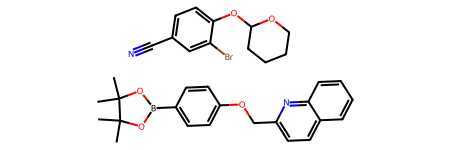

In [134]:
Chem.MolFromSmiles(reactant_smiles)

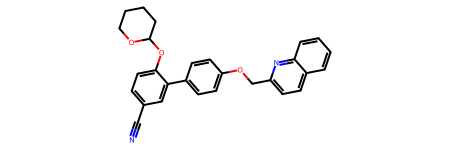

In [135]:
Chem.MolFromSmiles(product_smiles)

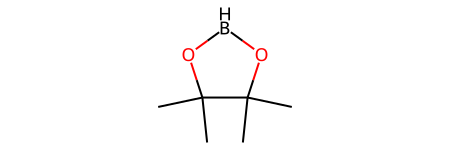

In [132]:
Chem.MolFromSmiles('CC1(C)OBOC1(C)C')

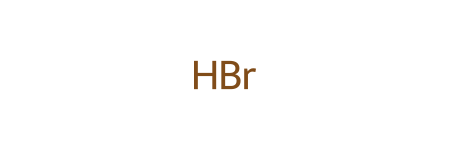

In [133]:
Chem.MolFromSmiles('Br')

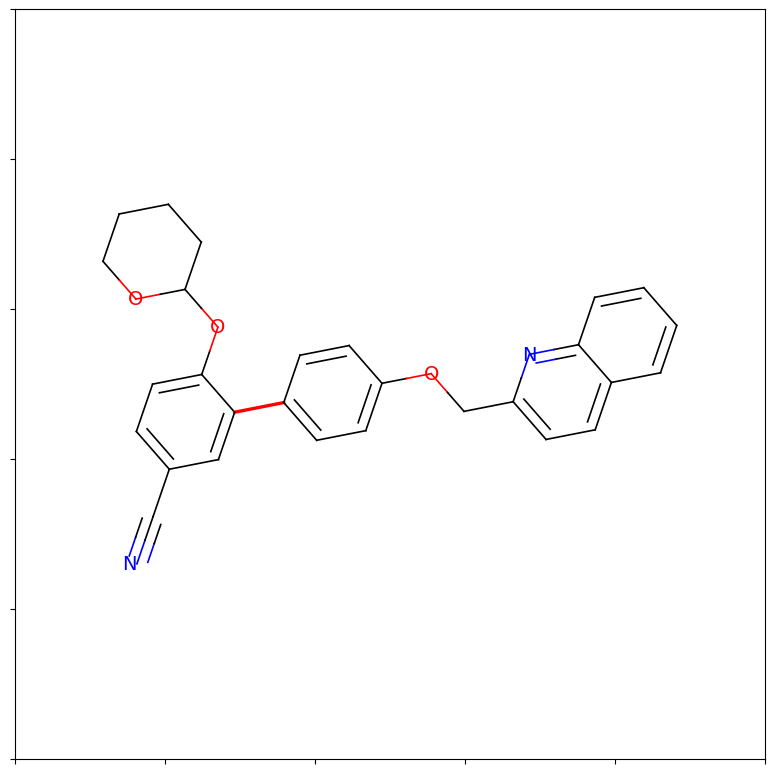

In [141]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, Draw
import matplotlib.pyplot as plt

class ChemicalGraphAnalyzer:
    @staticmethod
    def convert_smiles_to_mols(smiles):
        """
        Converts SMILES strings to RDKit molecule objects.
        """
        return [Chem.MolFromSmiles(s) for s in smiles.split('.')]

    @staticmethod
    def find_mcs(mols):
        """
        Finds the Maximum Common Substructure among a list of molecules.
        """
        mcs_result = rdFMCS.FindMCS(mols)
        return Chem.MolFromSmarts(mcs_result.smartsString)

    @staticmethod
    def find_attachment_points_in_product(mcs_mol, product_mol):
        """
        Finds attachment points in the product molecule where the MCS is connected.
        """
        attachment_points = []
        if product_mol.HasSubstructMatch(mcs_mol):
            match_idxs = product_mol.GetSubstructMatch(mcs_mol)
            for idx in match_idxs:
                atom = product_mol.GetAtomWithIdx(idx)
                for neighbor in atom.GetNeighbors():
                    if neighbor.GetIdx() not in match_idxs:
                        attachment_points.append(neighbor.GetIdx())
        return attachment_points

    @staticmethod
    def analyze_attachment_points(reactant_smiles, product_smiles):
        """
        Analyzes attachment points in the product based on reactant and product SMILES.
        """
        reactant_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(reactant_smiles)
        product_mol = Chem.MolFromSmiles(product_smiles)

        # Finding MCS for each reactant with the product
        mcs_mols = [ChemicalGraphAnalyzer.find_mcs([reactant_mol, product_mol]) for reactant_mol in reactant_mols]

        # Finding attachment points in the product
        attachment_points = []
        for mcs_mol in mcs_mols:
            if mcs_mol:
                points = ChemicalGraphAnalyzer.find_attachment_points_in_product(mcs_mol, product_mol)
                attachment_points.extend(points)

        return list(set(attachment_points))  # Removing duplicates

    @staticmethod
    def display_molecule_with_highlights(mol, highlight_atoms):
        """
        Displays a molecule with highlighted atoms.
        """
        fig = Draw.MolToMPL(mol, highlightAtoms=highlight_atoms, size=(300, 300))
        plt.show()

# Example usage
analyzer = ChemicalGraphAnalyzer()
reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

attachment_points = analyzer.analyze_attachment_points(reactant_smiles, product_smiles)
product_mol = Chem.MolFromSmiles(product_smiles)
analyzer.display_molecule_with_highlights(product_mol, attachment_points)


In [152]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

class ChemicalGraphAnalyzer:
    @staticmethod
    def find_attachment_points(reactant_mol, substructure_mol):
        """
        Find attachment points in the substructure that connect to other atoms in the reactant.
        Args:
            reactant_mol (rdkit.Chem.Mol): The reactant molecule.
            substructure_mol (rdkit.Chem.Mol): The substructure molecule.
        Returns:
            list: List of SMARTS patterns representing attachment points.
        """
        attachment_points = []

        # Get the atom indices of the substructure
        substructure_atoms = set(substructure_mol.GetSubstructMatch(substructure_mol))

        # Find attachment points by comparing atom indices
        for atom in reactant_mol.GetAtoms():
            if atom.GetIdx() not in substructure_atoms:
                attachment_points.append(atom.GetIdx())

        # Generate SMARTS patterns for attachment points
        smarts_patterns = [f"[{reactant_mol.GetAtomWithIdx(idx).GetSymbol()}]" for idx in attachment_points]

        return smarts_patterns

    @staticmethod
    def analyze_dissimilarity(reactant_smiles, product_smiles):
        """
        Analyze the dissimilarity between reactants and products based on their SMILES strings.
        Args:
            reactant_smiles (str): SMILES string for the reactants.
            product_smiles (str): SMILES string for the products.
        Returns:
            list: List of SMARTS patterns representing attachment points in dissimilar substructures.
        """
        reactant_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(reactant_smiles)
        product_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(product_smiles)

        # Finding MCS for each substructure in dissimilar_substructure with the corresponding reactant
        attachment_points_list = []
        for product_mol in product_mols:
            attachment_points = []
            for reactant_mol in reactant_mols:
                # Finding the MCS for this pair of substructure and reactant
                mcs_mol = ChemicalGraphAnalyzer.find_mcs([reactant_mol, product_mol])
                
                # Finding attachment points in this substructure
                attachment_points.extend(
                    ChemicalGraphAnalyzer.find_attachment_points(reactant_mol, mcs_mol)
                )
            
            attachment_points_list.append(attachment_points)

        return attachment_points_list

    @staticmethod
    def convert_smiles_to_mols(smiles):
        """
        Converts a SMILES string (or concatenated SMILES strings) to a list of RDKit molecule objects.
        Args:
            smiles (str): A SMILES string or concatenated SMILES strings.
        Returns:
            List[rdkit.Chem.Mol]: A list of molecule objects.
        """
        return [Chem.MolFromSmiles(s) for s in smiles.split('.')]

    @staticmethod
    def find_mcs(mols):
        """
        Finds the Maximum Common Substructure (MCS) among a list of molecules.
        Args:
            mols (List[rdkit.Chem.Mol]): List of molecule objects.
        Returns:
            rdkit.Chem.Mol: The MCS molecule.
        """
        mcs_result = rdFMCS.FindMCS(mols)
        return Chem.MolFromSmarts(mcs_result.smartsString)

# Define reactant and product SMILES strings
reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

# Create an instance of ChemicalGraphAnalyzer
analyzer = ChemicalGraphAnalyzer()

# Analyze dissimilarity and obtain attachment points
attachment_points_list = analyzer.analyze_dissimilarity(reactant_smiles, product_smiles)

# Print the SMARTS patterns for attachment points in each substructure
for idx, attachment_points in enumerate(attachment_points_list):
    print(f"Substructure {idx + 1} Attachment Points:")
    for attachment_point in attachment_points:
        print(f"- {attachment_point}")


Substructure 1 Attachment Points:
- [C]
- [C]
- [N]
- [C]
- [C]
- [O]
- [C]
- [C]
- [C]
- [C]


In [153]:
attachment_points_list

[['[C]', '[C]', '[N]', '[C]', '[C]', '[O]', '[C]', '[C]', '[C]', '[C]']]

In [154]:
attachment_points

['[C]', '[C]', '[N]', '[C]', '[C]', '[O]', '[C]', '[C]', '[C]', '[C]']

In [157]:
# Create an instance of ChemicalGraphAnalyzer
analyzer = ChemicalGraphAnalyzer()

# Define reactant and product SMILES strings
reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

# Analyze dissimilarity and obtain attachment points
attachment_points = analyzer.analyze_dissimilarity(reactant_smiles, product_smiles)

# Print the SMARTS patterns for attachment points
for idx, smarts_pattern in enumerate(attachment_points):
    print(f"Attachment Points in Dissimilar Substructure {idx + 1}: {smarts_pattern}")


Attachment Points: ['O', 'C', 'N']


In [155]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

class ChemicalGraphAnalyzer:
    @staticmethod
    def find_attachment_points(reactant_mol, substructure_mol):
        """
        Find attachment points in the substructure that connect to other atoms in the reactant.
        Args:
            reactant_mol (rdkit.Chem.Mol): The reactant molecule.
            substructure_mol (rdkit.Chem.Mol): The substructure molecule.
        Returns:
            list: List of SMARTS patterns representing attachment points.
        """
        attachment_points = []

        # Get the atom indices of the substructure
        substructure_atoms = set(substructure_mol.GetSubstructMatch(substructure_mol))

        # Find attachment points by comparing atom indices
        for atom in reactant_mol.GetAtoms():
            if atom.GetIdx() not in substructure_atoms:
                attachment_points.append(atom.GetIdx())

        # Generate SMARTS patterns for attachment points
        smarts_patterns = [f"[{reactant_mol.GetAtomWithIdx(idx).GetSymbol()}]" for idx in attachment_points]

        return smarts_patterns

    @staticmethod
    def analyze_dissimilarity(reactant_smiles, product_smiles):
        """
        Analyze the dissimilarity between reactants and products based on their SMILES strings.
        Args:
            reactant_smiles (str): SMILES string for the reactants.
            product_smiles (str): SMILES string for the products.
        Returns:
            list: List of SMARTS patterns representing attachment points in dissimilar substructures.
        """
        reactant_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(reactant_smiles)
        product_mols = ChemicalGraphAnalyzer.convert_smiles_to_mols(product_smiles)

        # Finding MCS for each substructure in dissimilar_substructure with the corresponding reactant
        attachment_points_list = []
        for product_mol in product_mols:
            attachment_points = []
            for reactant_mol in reactant_mols:
                # Finding the MCS for this pair of substructure and reactant
                mcs_mol = ChemicalGraphAnalyzer.find_mcs([reactant_mol, product_mol])
                
                # Finding attachment points in this substructure
                attachment_points.extend(
                    ChemicalGraphAnalyzer.find_attachment_points(reactant_mol, mcs_mol)
                )
            
            attachment_points_list.append(attachment_points)

        return attachment_points_list

    @staticmethod
    def convert_smiles_to_mols(smiles):
        """
        Converts a SMILES string (or concatenated SMILES strings) to a list of RDKit molecule objects.
        Args:
            smiles (str): A SMILES string or concatenated SMILES strings.
        Returns:
            List[rdkit.Chem.Mol]: A list of molecule objects.
        """
        return [Chem.MolFromSmiles(s) for s in smiles.split('.')]

    @staticmethod
    def find_mcs(mols):
        """
        Finds the Maximum Common Substructure (MCS) among a list of molecules.
        Args:
            mols (List[rdkit.Chem.Mol]): List of molecule objects.
        Returns:
            rdkit.Chem.Mol: The MCS molecule.
        """
        mcs_result = rdFMCS.FindMCS(mols)
        return Chem.MolFromSmarts(mcs_result.smartsString)

# Define reactant and product SMILES strings
reactant_smiles = 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1'
product_smiles = 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1'

# Create an instance of ChemicalGraphAnalyzer
analyzer = ChemicalGraphAnalyzer()

# Analyze dissimilarity and obtain attachment points
attachment_points_list = analyzer.analyze_dissimilarity(reactant_smiles, product_smiles)

# Print the SMARTS patterns for attachment points in each substructure
for idx, attachment_points in enumerate(attachment_points_list):
    print(f"Substructure {idx + 1} Attachment Points:")
    for attachment_point in attachment_points:
        print(f"- {attachment_point}")


Substructure 1 Attachment Points:
- [C]
- [C]
- [N]
- [C]
- [C]
- [O]
- [C]
- [C]
- [C]
- [C]


In [146]:
attachment_points

['', '']